In [12]:
import os
import json
from tqdm import tqdm
import warnings
from functools import partial

import numpy as np
import pandas as pd

from dpipe.io import load, save_json
from dpipe.dataset.wrappers import apply, cache_methods
from dpipe.im.metrics import dice_score, iou
from ood.dataset.cc359 import CC359
from ood.dataset.utils import Rescale3D, scale_mri
from ood.paths import CC359_DATA_PATH
from ood.utils import sdice
from ood.metric.ood_metric import calc_ood_scores, get_entropy, get_mutual_info, get_inconsistency_metrics

import matplotlib.pyplot as plt
%matplotlib inline

data_path = CC359_DATA_PATH

# if `voxel_spacing[i]` is `None` when `i`-th dimension will be used without scaling
voxel_spacing = (1, 0.95, 0.95)
sdice_metric = lambda x, y, i: sdice(x, y, dataset.load_spacing(i), 1)

in_distr_id = 2
n_folds = 6
ood_folds = [i for i in range(n_folds) if i != in_distr_id]
n_seeds = 5
bin_threshold = 0.5
eps = 1e-8

SEGMENTATION_METRICS = ['dice_score', 'sdice_score', 'froc_records']
SINGLE_NN_OOD_METRICS = ['maxprob', 'entropy']
SPATIAL_DIMS = (-3, -2, -1)
TOP_N_VOXELS = 500000

experiment_dir = '/shared/experiments/ood_playground/cc359/hippo_segm/ensemble/'


import os
from collections import defaultdict
from typing import Sequence, Callable

import numpy as np
from tqdm import tqdm
from skimage.measure import label

from dpipe.commands import load_from_folder
from dpipe.io import save_json, load_pred, save, load
from dpipe.im.metrics import dice_score
from dpipe.im.box import get_centered_box
from dpipe.im.shape_ops import crop_to_box
from dpipe.itertools import zip_equal
from ood.utils import volume2diameter, get_pred
from ood.batch_iter.pipeline import SPATIAL_DIMS, sample_center_uniformly

In [367]:
def visualize_ood_statistics_folds(labels, metrics):
    fontsize = 14
    
    ood_metrics = np.zeros((n_folds))

    ids = set(dataset.df[dataset.df['fold'] == in_distr_id].index)
    metric_keys = set(metrics.keys())
    ids = metric_keys.intersection(ids)

    in_distr_metric = np.mean([metrics[uid] for uid in ids])
    ood_metrics[in_distr_id] = in_distr_metric
    print(f'In distribution: {in_distr_metric:.4f}')

    for fold_id in ood_folds:
        ids = list(dataset.df[dataset.df['fold'] == fold_id].index)

        ood_metric = np.mean([metrics[uid] for uid in ids])
        ood_metrics[fold_id] = ood_metric
        print(f'OOD fold {fold_id}: {ood_metric:.4f}')

    labels_arr = np.array(list(labels.values()))
    folds = np.array([dataset.df.fold[uid] for uid in labels.keys()])
    is_ood_true = np.array([dataset.df.fold[uid] != in_distr_id for uid in labels.keys()])
    sorted_ids = np.argsort(labels_arr)
#     print(is_ood_true[sorted_ids])
#     print(folds[sorted_ids])

    ordered_metrics = {uid: metrics[uid] for uid in labels.keys()}
    ordered_metrics_arr = np.array(list(ordered_metrics.values()))

#     for fold in range(n_folds):
#         plt.hist(labels_arr[folds == fold], alpha=0.5, 
#                  label=f'{fold}: sDSC drop {(ood_metrics[in_distr_id] - ood_metrics[fold]):.3f}')

#     plt.title('Histogram with uncertainty scores for different domains')
#     plt.xlabel('Uncertainty score')
#     plt.legend()
#     plt.show()

#     for fold in range(n_folds):
#         label = f'{fold}: sDSC drop {(ood_metrics[in_distr_id] - ood_metrics[fold]):.3f}'
#         if fold == in_distr_id:
#             label = f'{fold}: in-distribution'
#         plt.scatter(labels_arr[folds == fold], ordered_metrics_arr[folds == fold], alpha=1, 
#                     label=label)

    lab_folds = []
    for fold in folds:
        label = f'{fold}: sDSC drop {(ood_metrics[in_distr_id] - ood_metrics[fold]):.3f}'
        if fold == in_distr_id:
            label = f'{fold}: in-distribution'
        lab_folds.append(label)
            
            
    data=pd.DataFrame(np.concatenate([labels_arr[:, None], 
                                      ordered_metrics_arr[:, None]], axis=1))
    data['domains'] = lab_folds
        
    data = data.sort_values(['domains'])
    
    data.columns = ['a', 'b', 'Domains']
    plt.figure(figsize=(15, 6))
    sns.lmplot(data=data, x='a', y='b', hue='Domains', aspect=2)
    #labels_arr[folds == fold], ordered_metrics_arr[folds == fold]) 
#                     label=label)

    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

#     plt.title('Dependence between segmentation quality and uncertainty score')
    plt.xlabel('Uncertainty score', fontsize=fontsize)
    plt.ylabel('Surface Dice Score', fontsize=fontsize)
#     plt.legend(fontsize=fontsize, bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
#     plt.grid()
    plt.show()

In [368]:
import seaborn as sns
sns.set();
sns.set(rc={'figure.figsize':(20,8.27)})

In [369]:
experiment_dir = '/shared/experiments/ood_playground/cc359/brain_segm/ensemble/'

In distribution: 0.9528
OOD fold 0: 0.8998
OOD fold 1: 0.8651
OOD fold 3: 0.7827
OOD fold 4: 0.9494
OOD fold 5: 0.8456


<Figure size 1080x432 with 0 Axes>

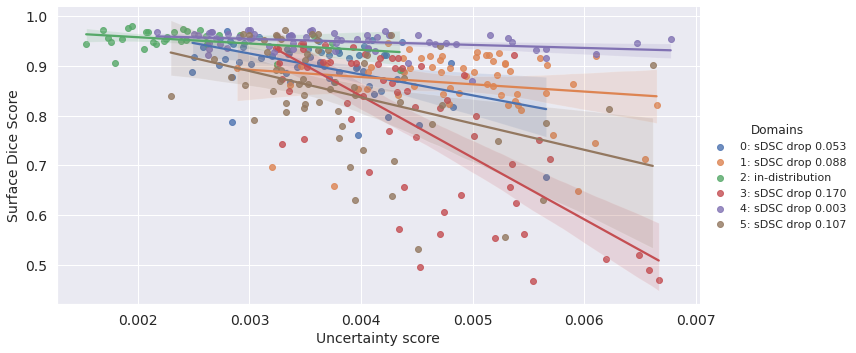

In [370]:
seed = 0
labels = load(os.path.join(experiment_dir, f'svd_3/experiment_0/test_metrics/min_distance.json'))
metrics = load(os.path.join(experiment_dir, f'seed{seed}/experiment_0/test_metrics/sdice_score.json'))
train_ids = load(os.path.join(experiment_dir, f'seed{seed}/experiment_0/train_ids.json'))
labels = {uid: labels[uid] for uid in labels.keys() if uid not in train_ids}


visualize_ood_statistics_folds(labels, metrics)

In [350]:
len(labels)

329

### Ensemble

In [148]:
def save_ensemble_metrics(exp_dir, has_targets=False, load_y=None):
    dices = {}
    sdices = {}
    ensemble_labels = {}

    base_dir = os.path.join(exp_dir, f'seed0/experiment_0/test_predictions')
    filenames = os.listdir(base_dir)
    uids = ['.'.join(fname.split('.')[:-1]) for fname in filenames]

    for uid in tqdm(uids):
        ensemble_preds = []
        for seed in range(n_seeds):
            base_dir = os.path.join(exp_dir, f'seed{seed}/experiment_0/test_predictions')
            preds = load(os.path.join(base_dir, uid + '.npy')).astype(np.float32)
            ensemble_preds.append(preds)

        ensemble_preds = np.array(ensemble_preds)
        mean_preds = ensemble_preds.mean(axis=0)
        ensemble_labels[uid] = get_inconsistency_metrics(ensemble_preds, top_n_voxels=TOP_N_VOXELS)
        # get segmentation metrics
        
        if has_targets:
            true_mask = load_y(uid)
            dices[uid] = dice_score(mean_preds > bin_threshold, true_mask > bin_threshold)
            sdices[uid] = sdice_metric(mean_preds > bin_threshold, true_mask > bin_threshold, uid)

    # save results
    results = ensemble_labels
    results_path = os.path.join(exp_dir, 'final_metrics')
    os.makedirs(results_path, exist_ok=True)

    for agg_func_name in results[list(results.keys())[0]].keys():
        result = {_id: results[_id][agg_func_name] for _id in results.keys()}
        save_json(result, os.path.join(results_path, agg_func_name + '.json'), indent=0)

    if has_targets:
        save_json(dices, os.path.join(results_path, 'dice_score.json'), indent=0)
        save_json(sdices, os.path.join(results_path, 'sdice_score.json'), indent=0)

In [116]:
experiment_dir = '/shared/experiments/ood_playground/luna/midrc/'

In [69]:
load_y = lambda uid: dataset.load_segm(uid)
save_ensemble_metrics(experiment_dir, load_y=load_y, has_targets=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 323/323 [1:26:12<00:00, 16.01s/it]


In [123]:
k = 1 # angle of rotation (90 degrees)
load_y = lambda uid: np.rot90(dataset.load_segm(uid), k=k, axes=(SPATIAL_DIMS[0], SPATIAL_DIMS[1]))
save_ensemble_metrics('/shared/experiments/ood_playground/cc359/hippo_segm/crops_and_flips/rot/', 
                      load_y=load_y, has_targets=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [06:20<00:00, 12.70s/it]


In [124]:
ax = 1
load_y = lambda uid: np.flip(dataset.load_segm(uid), axis=SPATIAL_DIMS[:2][ax])
save_ensemble_metrics('/shared/experiments/ood_playground/cc359/hippo_segm/crops_and_flips/flip/', 
                      load_y=load_y, has_targets=True)

 30%|████████████████████████████▏                                                                 | 9/30 [01:53<04:26, 12.69s/it]/homes/dfrolova/ood-playground/ood/metric/ood_metric.py:178: RuntimeWarning: invalid value encountered in double_scalars
  labels['mean_volume'] = std_volume / mean_volume
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [06:17<00:00, 12.59s/it]


In [125]:
save_ensemble_metrics('/shared/experiments/ood_playground/cc359/hippo_segm/crops_and_flips/crop/')

  5%|████▎                                                                                        | 7/150 [00:26<08:29,  3.56s/it]/homes/dfrolova/ood-playground/ood/metric/ood_metric.py:178: RuntimeWarning: invalid value encountered in double_scalars
  labels['mean_volume'] = std_volume / mean_volume
  7%|██████▋                                                                                     | 11/150 [00:35<06:28,  2.79s/it]/homes/dfrolova/ood-playground/ood/metric/ood_metric.py:178: RuntimeWarning: invalid value encountered in double_scalars
  labels['mean_volume'] = std_volume / mean_volume
 26%|███████████████████████▉                                                                    | 39/150 [02:07<08:45,  4.74s/it]/homes/dfrolova/ood-playground/ood/metric/ood_metric.py:178: RuntimeWarning: invalid value encountered in double_scalars
  labels['mean_volume'] = std_volume / mean_volume
 29%|██████████████████████████▉                                                              

In [81]:
experiment_dir = '/shared/experiments/ood_playground/cc359/brain_segm/harp/'
save_ensemble_metrics(experiment_dir)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 135/135 [23:58<00:00, 10.66s/it]


In [195]:
experiment_dir = '/shared/experiments/ood_playground/luna/crop/'
save_ensemble_metrics(experiment_dir)

  7%|██████▊                                                                                     | 16/218 [01:34<22:13,  6.60s/it]/homes/dfrolova/ood-playground/ood/metric/ood_metric.py:179: RuntimeWarning: invalid value encountered in double_scalars
  labels['mean_volume'] = std_volume / mean_volume
 31%|████████████████████████████▎                                                               | 67/218 [07:09<13:22,  5.31s/it]/homes/dfrolova/ood-playground/ood/metric/ood_metric.py:179: RuntimeWarning: invalid value encountered in double_scalars
  labels['mean_volume'] = std_volume / mean_volume
 55%|█████████████████████████████████████████████████▋                                         | 119/218 [12:34<21:20, 12.93s/it]/homes/dfrolova/ood-playground/ood/metric/ood_metric.py:179: RuntimeWarning: invalid value encountered in double_scalars
  labels['mean_volume'] = std_volume / mean_volume
 64%|██████████████████████████████████████████████████████████                               

In [129]:
experiment_dir = '/shared/experiments/ood_playground/midrc/medseg9/'
save_ensemble_metrics(experiment_dir)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:41<00:00,  4.60s/it]


In [ ]:
experiment_dir = '/shared/experiments/ood_playground/cc359/brain_segm/heart/'
save_ensemble_metrics(experiment_dir)

 15%|██████████████                                                                                | 3/20 [02:09<11:38, 41.11s/it]

In [2]:
def get_avg_volume(exp_dir):
    mean_volumes = []

    base_dir = os.path.join(exp_dir, f'seed0/experiment_0/test_predictions')
    filenames = os.listdir(base_dir)
    uids = ['.'.join(fname.split('.')[:-1]) for fname in filenames]

    for seed in range(n_seeds):
        volumes = []
        base_dir = os.path.join(exp_dir, f'seed{seed}/experiment_0/test_predictions')
        os.makedirs(os.path.join(exp_dir, f'seed{seed}/experiment_0/test_statistics'))
        for uid in tqdm(uids):
            preds = load(os.path.join(base_dir, uid + '.npy')).astype(np.float32)
            mean = np.mean(preds > 0.5)
            volumes.append(mean)
        mean_volumes.append(np.mean(volumes))
    return mean_volumes

In [3]:
get_avg_volume('/shared/experiments/ood_playground/cc359/brain_segm/heart/')

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.17s/it]


[0.3256533654182655,
 0.2684339413519926,
 0.26057955510723385,
 0.3044518406730596,
 0.2983360802377692]

In [4]:
np.mean([0.3256533654182655,
 0.2684339413519926,
 0.26057955510723385,
 0.3044518406730596,
 0.2983360802377692])

0.29149095655766416

In [5]:
np.std([0.3256533654182655,
 0.2684339413519926,
 0.26057955510723385,
 0.3044518406730596,
 0.2983360802377692])

0.023954336159584016

In [32]:
def get_avg_volume_mask():

    uids = ['CC0246', 'CC0271', 'CC0299', 'CC0240', 'CC0286', 'CC0242', 'CC0259', 'CC0250', 
            'CC0265', 'CC0295', 'CC0249', 'CC0252', 'CC0258', 'CC0247', 'CC0243', 'CC0260', 
            'CC0288', 'CC0278', 'CC0270', 'CC0268', 'CC0266', 'CC0281', 'CC0272', 'CC0251', 
            'CC0277', 'CC0280', 'CC0276', 'CC0292', 'CC0264', 'CC0241']

    volumes = []
    for uid in tqdm(uids):
        segm = dataset.load_segm(uid)
        mean = np.mean(segm > 0.5)
        volumes.append(mean)
    return volumes

In [33]:
vols = get_avg_volume_mask()

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [04:02<00:00,  8.07s/it]


In [34]:
np.mean(vols), np.std(vols)

(0.1025280462753487, 0.009248322811659866)

In [36]:
segm = dataset.load_segm(dataset.ids[0])

In [40]:
np.mean((segm > 0.5)[..., 130])

0.3939868258005609

In [38]:
segm.shape

(171, 269, 269)

In [41]:
def save_pred_mean_std(exp_dir):
    dices = {}
    sdices = {}
    ensemble_labels = {}

    base_dir = os.path.join(exp_dir, f'seed0/experiment_0/test_predictions')
    filenames = os.listdir(base_dir)
    uids = ['.'.join(fname.split('.')[:-1]) for fname in filenames]

    for seed in range(n_seeds):
        base_dir = os.path.join(exp_dir, f'seed{seed}/experiment_0/test_predictions')
        os.makedirs(os.path.join(exp_dir, f'seed{seed}/experiment_0/test_statistics'))
        for uid in tqdm(uids):
            preds = load(os.path.join(base_dir, uid + '.npy')).astype(np.float32)
            mean = np.mean(preds)
            std = np.std(preds)
            res = np.array([mean, std])
            save(res, os.path.join(exp_dir, f'seed{seed}/experiment_0/test_statistics/{uid}.npy'))

In [69]:
save_pred_mean_std('/shared/experiments/ood_playground/luna/flips/')

100%|███████████████████████████████████████████████████████████████████████████████████████████| 218/218 [04:50<00:00,  1.33s/it]


In [34]:
save_pred_mean_std('/shared/experiments/ood_playground/luna/midrc/')

100%|███████████████████████████████████████████████████████████████████████████████████████████| 154/154 [02:30<00:00,  1.03it/s]


In [128]:
save_pred_mean_std('/shared/experiments/ood_playground/midrc/medseg9/')

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  4.09it/s]


In [119]:
len(os.listdir('/shared/experiments/ood_playground/luna/flips/svd_19/experiment_0/test_predictions/'))

218

In [116]:
len(load(f'/shared/experiments/ood_playground/luna/lits/seed0/experiment_0/test_metrics/froc_records.json'))

201

In [72]:
seed = 4
path1 = f'/shared/experiments/ood_playground/luna/flips/new_metr/seed{seed}_old/experiment_0/test_metrics/'
for metric_file in os.listdir(path1):
    
    metric1 = load(f'/shared/experiments/ood_playground/luna/flips/new_metr/seed{seed}_old/experiment_0/test_metrics/{metric_file}')
    metric2 = load(f'/shared/experiments/ood_playground/luna/flips/new_flips/seed{seed}/experiment_0/test_metrics/{metric_file}')
    
    metric = {**metric1, **metric2}
    print(len(metric))
    save_json(metric, f'/shared/experiments/ood_playground/luna/flips/seed{seed}/experiment_0/test_metrics/{metric_file}')

218
218
218
218
218


In [50]:
len(metric1) + len(metric2)

218

In [52]:
len(metric)

218

In [3]:
import numpy as np

from dpipe.dataset.wrappers import apply, cache_methods
from ood.dataset.task4_hippo import Task4Hippo
from ood.dataset.utils import scale_mri, Rescale3D
from ood.paths import TASK4_HIPPO_PATH


data_path = TASK4_HIPPO_PATH

# if `voxel_spacing[i]` is `None` when `i`-th dimension will be used without scaling
# voxel_spacing = (None, None, None)
voxel_spacing = (1, 0.95, 0.95)

preprocessed_dataset = apply(Rescale3D(Task4Hippo(data_path), voxel_spacing), load_image=scale_mri)
dataset = apply(cache_methods(apply(preprocessed_dataset, load_image=np.float16), maxsize=30), load_image=np.float32)

In [4]:
load_y = dataset.load_segm
save_ensemble_metrics('/shared/experiments/ood_playground/cc359/hippo_segm/task4_hippo/', load_y=load_y)

  0%|                                                                                                     | 0/260 [00:00<?, ?it/s]/homes/dfrolova/ood-playground/ood/metric/ood_metric.py:178: RuntimeWarning: invalid value encountered in double_scalars
  labels['mean_volume'] = std_volume / mean_volume
  1%|█                                                                                            | 3/260 [00:00<00:10, 25.53it/s]/homes/dfrolova/ood-playground/ood/metric/ood_metric.py:178: RuntimeWarning: invalid value encountered in double_scalars
  labels['mean_volume'] = std_volume / mean_volume
/homes/dfrolova/ood-playground/ood/metric/ood_metric.py:178: RuntimeWarning: invalid value encountered in double_scalars
  labels['mean_volume'] = std_volume / mean_volume
  3%|███▏                                                                                         | 9/260 [00:00<00:09, 27.35it/s]/homes/dfrolova/ood-playground/ood/metric/ood_metric.py:178: RuntimeWarning: invalid value enc

/homes/dfrolova/ood-playground/ood/metric/ood_metric.py:178: RuntimeWarning: invalid value encountered in double_scalars
  labels['mean_volume'] = std_volume / mean_volume
 55%|██████████████████████████████████████████████████▍                                        | 144/260 [00:04<00:03, 33.35it/s]/homes/dfrolova/ood-playground/ood/metric/ood_metric.py:178: RuntimeWarning: invalid value encountered in double_scalars
  labels['mean_volume'] = std_volume / mean_volume
 57%|███████████████████████████████████████████████████▊                                       | 148/260 [00:04<00:03, 33.22it/s]/homes/dfrolova/ood-playground/ood/metric/ood_metric.py:178: RuntimeWarning: invalid value encountered in double_scalars
  labels['mean_volume'] = std_volume / mean_volume
 58%|█████████████████████████████████████████████████████▏                                     | 152/260 [00:04<00:03, 34.00it/s]/homes/dfrolova/ood-playground/ood/metric/ood_metric.py:178: RuntimeWarning: invalid value enc

In [7]:
load_y = dataset.load_segm
save_ensemble_metrics('/shared/experiments/ood_playground/cc359/hippo_segm/harp/', load_y=load_y)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 135/135 [10:16<00:00,  4.57s/it]


In [26]:
def get_score_augmentation(true_labels, augm_labels, print_results=True, is_segm_metric=False):
    if type(augm_labels) == dict:
        augm_labels = list(augm_labels.values())
    scores = np.array(list(true_labels.values()) + augm_labels)
    y_true = np.array([False] * len(true_labels) + [True] * len(augm_labels))
    if is_segm_metric:
        y_true = ~y_true
    return calc_ood_scores(scores, y_true, print_results=print_results)


def filter_metrics(metrics, ids):
    return {uid: metrics[uid] for uid in ids}

def filter_metrics_crops(metrics):
    return metrics
#     return {uid: metrics[uid] for uid in metrics.keys() if uid.endswith('_1')}


def add_row(result_df, row_list):
    for i in range(len(row_list)):
        if type(row_list[i]) == np.float64:
            row_list[i] = np.round(row_list[i], 3)
    result_df.loc[result_df.shape[0]] = row_list


def calc_ood_statistics_new_dataset(result_df, ind_exp_dir, ood_exp_dir, method_name, ind_ids=None, 
                                    has_single_ue_scores=True, has_incosnsistency_scores=True):
        
    metric_file = os.listdir(ind_exp_dir)[0]
    ind_labels = load(os.path.join(ind_exp_dir, metric_file))
    if ind_ids is None:
        ind_ids = list(ind_labels.keys())

    if has_single_ue_scores:
        for metric_name in SINGLE_NN_OOD_METRICS:
            ind_labels = load(os.path.join(ind_exp_dir, metric_name + '.json'))
            ind_labels = filter_metrics(ind_labels, ind_ids)
            ood_labels = load(os.path.join(ood_exp_dir, metric_name + '.json'))
            
            # TODO REMOVE
#             ind_labels = filter_metrics_crops(ind_labels)
            ood_labels = filter_metrics_crops(ood_labels)
            
            det_acc, auc, tnr = get_score_augmentation(ind_labels, ood_labels, print_results=False)
            add_row(result_df, [method_name, metric_name, det_acc, auc, tnr])

    if has_incosnsistency_scores:
        for metric_file in os.listdir(ind_exp_dir):
            metric_name = metric_file.split('.json')[0]
            if metric_name in SEGMENTATION_METRICS or metric_name in SINGLE_NN_OOD_METRICS:
                continue
            ind_labels = load(os.path.join(ind_exp_dir, metric_name + '.json'))
            ind_labels = filter_metrics(ind_labels, ind_ids)
            ood_labels = load(os.path.join(ood_exp_dir, metric_name + '.json'))
            if np.isnan(np.array(list(ood_labels.values())).astype(float)).any():
                print(f'Skip {metric_name} calculation for {method_name} as it contains Nans')
                continue
            if np.isnan(np.array(list(ind_labels.values())).astype(float)).any():
                print(f'Skip {metric_name} calculation for {method_name} as it contains Nans')
                continue
                
            # TODO REMOVE    
#             ind_labels = filter_metrics_crops(ind_labels)
            ood_labels = filter_metrics_crops(ood_labels)
                
            det_acc, auc, tnr = get_score_augmentation(ind_labels, ood_labels, print_results=False)
            add_row(result_df, [method_name, metric_name, det_acc, auc, tnr])
            
            
def calc_ood_statistics(result_df, method_name, exp_dir, in_distr_id, uid_folds,
                        has_single_ue_scores=True, has_incosnsistency_scores=True):

    if has_single_ue_scores:
        for metric_name in SINGLE_NN_OOD_METRICS:
            labels = load(os.path.join(exp_dir, metric_name + '.json'))
            is_ood_true = np.array([uid_folds[uid] != in_distr_id for uid in labels.keys()])
            det_acc, auc, tnr = calc_ood_scores(np.array(list(labels.values())), is_ood_true, print_results=False)
            add_row(result_df, [method_name, metric_name, det_acc, auc, tnr])

    if has_incosnsistency_scores:
        for metric_file in os.listdir(exp_dir):
            metric_name = metric_file.split('.json')[0]
            if metric_name in SEGMENTATION_METRICS or metric_name in SINGLE_NN_OOD_METRICS:
                continue
            
            labels = load(os.path.join(exp_dir, metric_file))
            if method_name != 'Deep Ensembles':
                # drop train ids from labels
                train_ids = load('/'.join(exp_dir.split('/')[:-2]) + '/train_ids.json')
                labels = {uid: labels[uid] for uid in labels.keys() if uid not in train_ids}
            is_ood_true = np.array([uid_folds[uid] != in_distr_id for uid in labels.keys()])
            det_acc, auc, tnr = calc_ood_scores(np.array(list(labels.values())), is_ood_true, print_results=False)
            add_row(result_df, [method_name, metric_name, det_acc, auc, tnr])
            
            
def get_segm_drops(experiment_dir, uid_folds):

    print('SEGMENTATION DROPS')
    for metric_name in ['dice_score', 'sdice_score']:
        
        print(f'\n{metric_name}')

        ood_metrics = np.zeros((n_folds, n_seeds))

        for seed in range(n_seeds):
            base_dir = os.path.join(experiment_dir, f'seed{seed}/experiment_0/')
            metrics = load(os.path.join(base_dir, 'test_metrics', f'{metric_name}.json'))

            ids = set(uid_folds[uid_folds == in_distr_id].index)
            metric_keys = set(metrics.keys())
            ids = metric_keys.intersection(ids)

            in_distr_metric = np.mean([metrics[uid] for uid in ids])
            ids = list(ids)
            ood_metrics[in_distr_id, seed] = in_distr_metric

            for fold_id in ood_folds:
                ids = list(uid_folds[uid_folds == fold_id].index)

                ood_metric = np.mean([metrics[uid] for uid in ids])
                ood_metrics[fold_id, seed] = ood_metric

        means = ood_metrics.mean(axis=1)
        stds = ood_metrics.std(axis=1)
        drops = ood_metrics[in_distr_id] - ood_metrics[ood_folds].mean(axis=0)

        print(f'In distr:\t\t{means[in_distr_id]:.4f} ± {stds[in_distr_id]:.4f}')
        print(f'OOD:\t\t\t{ood_metrics[ood_folds].mean():.4f} ± {ood_metrics[ood_folds].std():.4f}')
        print(f'{metric_name} drop:\t{drops.mean():.4f} ± {drops.std():.4f}')
        
        
def get_baseline_results(result_df, experiment_dir, method_name, uid_folds):
    for ue_method in['maxprob', 'entropy']:
        det_accs = []
        roc_aucs = []
        tprs = []
        labels_list = []

        for seed in range(n_seeds):
            base_dir = os.path.join(experiment_dir, f'seed{seed}/experiment_0/test_predictions')
            labels = load(os.path.join(experiment_dir,f'seed{seed}/experiment_0/test_metrics/{ue_method}.json'))
            labels_list.append(labels)

            is_ood_true = np.array([uid_folds[uid] != in_distr_id for uid in labels.keys()])
            det_acc, roc_auc, tpr = calc_ood_scores(np.array(list(labels.values())), is_ood_true, 
                                                    print_results=False)
            det_accs.append(det_acc)
            roc_aucs.append(roc_auc)
            tprs.append(tpr)
            
        add_row(result_df, [method_name, ue_method, np.mean(det_accs), np.mean(roc_aucs),
                            np.mean(tprs)])
        
        
# def print_ood_metrics(means, stds):
#     print(f'Detection accuracy: {means[0]:.4f} ± {1.96 * stds[0]:.4f}')
#     print(f'AUROC: {means[1]:.4f} ± {1.96 * stds[1]:.4f}')
#     print(f'TNR @ 95% TPR: {means[2]:.4f} ± {1.96 * stds[2]:.4f}')


def get_drops_and_baselines_new_dataset(result_df, method_name, ind_experiment_dir, ood_experiment_dir,
                                        seeds=range(n_seeds), has_segm_metrics=True, segm_metrics=None, 
                                        ind_ids=None, calc_froc=False):
    
    if segm_metrics is None:
        segm_metrics = ['dice_score', 'sdice_score']
    ue_metrics = ['maxprob', 'entropy']
    
    if ind_ids is None:
        ind_ids = list(load(os.path.join(ind_exp_dir, f'test_metrics/{ue_metrics[0]}.json')).keys())
    
    if calc_froc:
        ind_segms = {metric: [] for metric in segm_metrics +
                     ['avg_object_dice', 'avg_recall', 'AvgFP', 'Frac_empty_preds']}
        ood_segms = {metric: [] for metric in segm_metrics + 
                     ['avg_object_dice', 'avg_recall', 'AvgFP', 'Frac_empty_preds']}
        drops = {metric: [] for metric in segm_metrics + 
                 ['avg_object_dice', 'avg_recall', 'AvgFP', 'Frac_empty_preds']}
    else:
        ind_segms = {metric: [] for metric in segm_metrics}
        ood_segms = {metric: [] for metric in segm_metrics}
        drops = {metric: [] for metric in segm_metrics}
        
    ood_metrics = {metric: [] for metric in ue_metrics}
            
    for seed in seeds:
        ind_exp_dir = os.path.join(ind_experiment_dir, f'seed{seed}/experiment_0/')
        ood_exp_dir = os.path.join(ood_experiment_dir, f'seed{seed}/experiment_0/')
        
        if has_segm_metrics:
            for segm_metric in segm_metrics:
                if segm_metric.split('_')[-1] == 'padded':
                    segm_metric_ind = '_'.join(segm_metric.split('_')[:-1])
                else:
                    segm_metric_ind = segm_metric
                ind_segm_metrics = load(os.path.join(ind_exp_dir, f'test_metrics/{segm_metric_ind}.json'))
                ood_segm_metrics = load(os.path.join(ood_exp_dir, f'test_metrics/{segm_metric}.json'))
                ind_segm = np.mean([ind_segm_metrics[uid] for uid in ind_ids]) # filter uids
                ood_segm = np.mean(list(ood_segm_metrics.values()))
                
                # TODO REMOVE
#                 ind_segm = np.mean([ind_segm_metrics[uid] for uid in ind_ids if uid.endswith('_1')]) # filter uids
                ood_segm_metrics = filter_metrics_crops(ood_segm_metrics)
                ood_segm = np.mean(list(ood_segm_metrics.values()))
                
                ind_segms[segm_metric].append(ind_segm)
                ood_segms[segm_metric].append(ood_segm)
                drops[segm_metric].append(ind_segm - ood_segm)
                
            if calc_froc:
                ind_froc_results = load(os.path.join(ind_exp_dir, f'test_metrics/froc_metrics.json'))
                ood_froc_results = load(os.path.join(ood_exp_dir, f'test_metrics/froc_metrics.json'))
                
                # TODO REMOVE
#                 ind_froc_results = filter_metrics_crops(ind_froc_results)
                ood_froc_results = filter_metrics_crops(ood_froc_results)
                
                for segm_metric in ['avg_object_dice', 'avg_recall', 'AvgFP', 'Frac_empty_preds']:
                    ind_segm = ind_froc_results[segm_metric]
                    ood_segm = ood_froc_results[segm_metric]
                    ind_segms[segm_metric].append(ind_segm)
                    ood_segms[segm_metric].append(ood_segm)
                    drops[segm_metric].append(ind_segm - ood_segm)
            
        for ue_metric in ue_metrics:
            ind_labels = load(os.path.join(ind_exp_dir, f'test_metrics/{ue_metric}.json'))
            ood_labels = load(os.path.join(ood_exp_dir, f'test_metrics/{ue_metric}.json'))
            ind_labels = {uid: ind_labels[uid] for uid in ind_ids} # filter uids
            
            # TODO REMOVE
#             ind_labels = filter_metrics_crops(ind_labels)
            ood_labels = filter_metrics_crops(ood_labels)
            
            ood_metrics[ue_metric].append(list(get_score_augmentation(ind_labels, ood_labels, 
                                                                      print_results=False)))
    
    if has_segm_metrics:
        for metric_name in drops.keys():
            cur_ind_segm = np.array(ind_segms[metric_name])
            cur_ood_segm = np.array(ood_segms[metric_name])
            cur_drop = np.array(drops[metric_name])
            print(f'\n{metric_name}')
            print(f'In distr:\t\t{cur_ind_segm.mean():.4f} ± {cur_ind_segm.std():.4f}')
            print(f'OOD:\t\t\t{cur_ood_segm.mean():.4f} ± {cur_ood_segm.std():.4f}')
            print(f'{metric_name} drop:\t{cur_drop.mean():.4f} ± {cur_drop.std():.4f}')
        
    for ue_metric in ue_metrics:
        cur_metric = np.array(ood_metrics[ue_metric])
        means = cur_metric.mean(axis=0)
        add_row(result_df, [method_name, ue_metric, means[0], means[1], means[2]])

In [27]:
def filter_iou_top_n(results_data):
#     return results_data
    return results_data[~results_data.agg_function.isin(['mean_iou', 'top_n_500000_std', 'top_n_500000_var', 
                                                         'top_n_1000000_std', 'top_n_1000000_var', 'mean_distance',
                                                         'mean_distance_scale', 'mean_distance_norm',
                                                         'top_n_2000000_std', 'top_n_2000000_var', 'std',
                                                         'distance_from_center', 'distance_from_center_scale',
                                                         'distance_from_center_norm',
                                                         '5_percentile', '5_percentile_norm', '5_percentile_scale',
                                                         'entropy',
                                                         'mean_volume', 'mean_dice',
                                                         'mut_info', 'min_distance_scale'
                                                        ])]#.sort_values('TNR @ 95 TPR', ascending=False)


def get_all_metrics(exp_dir, filter_func, data_name, methods_dict, uid_folds, in_distr_id=in_distr_id):
    results_data = pd.DataFrame(columns=COLUMN_NAMES)
    get_segm_drops(exp_dir, uid_folds=uid_folds)
    get_baseline_results(results_data, experiment_dir=exp_dir, method_name='Baseline', uid_folds=uid_folds)
    
    for method_name in methods_dict:
        method_folder = methods_dict[method_name]
        
        if method_folder != 'final_metrics':
            ind_exp_dir = os.path.join(exp_dir, method_folder, 'experiment_0/test_metrics/')
        else:
            ind_exp_dir = os.path.join(exp_dir, method_folder)
        print(method_name)
        calc_ood_statistics(results_data, method_name, ind_exp_dir, 
                            in_distr_id=in_distr_id, uid_folds=uid_folds,
                            has_single_ue_scores=False, has_incosnsistency_scores=True)

    print('\n' + data_name)
    return filter_func(results_data)


def get_all_metrics_new_dataset(ind_experiment_dir, ood_experiment_dir, filter_func, data_name, methods_dict,
                                segm_metrics=None, ind_ids_type=None, cc359_dataset=None, has_segm_metrics=True,
                                in_distr_id=in_distr_id, seeds=range(n_seeds), calc_froc=False):
    
    ind_ids = load(os.path.join(ind_experiment_dir, 'seed0/experiment_0/test_ids.json'))
    if ind_ids_type == 'CC359':
        ind_ids = [uid for uid in ind_ids if cc359_dataset.df.fold[uid] == in_distr_id]        
    
    results_data = pd.DataFrame(columns=COLUMN_NAMES)
    get_drops_and_baselines_new_dataset(results_data, method_name='Baseline', 
                                        ind_experiment_dir=ind_experiment_dir, 
                                        ood_experiment_dir=ood_experiment_dir, seeds=seeds, 
                                        has_segm_metrics=has_segm_metrics,
                                        segm_metrics=segm_metrics, ind_ids=ind_ids, calc_froc=calc_froc)

    
    for method_name in methods_dict:
        method_folder = methods_dict[method_name]
        
        if method_folder != 'final_metrics':
            ind_exp_dir = os.path.join(ind_experiment_dir, method_folder, 'experiment_0/test_metrics/')
            ood_exp_dir = os.path.join(ood_experiment_dir, method_folder, 'experiment_0/test_metrics/')
        else:
            ind_exp_dir = os.path.join(ind_experiment_dir, method_folder)
            ood_exp_dir = os.path.join(ood_experiment_dir, method_folder)
         
        print(method_name)
        calc_ood_statistics_new_dataset(results_data, ind_exp_dir, ood_exp_dir, method_name, ind_ids=ind_ids, 
                                        has_single_ue_scores=False, has_incosnsistency_scores=True)

    print('\n' + data_name)
    return filter_func(results_data)

## CC359 brain segmentation

In [21]:
COLUMN_NAMES = ['method', 'agg_function', 'Det acc', 'AUROC', 'TNR @ 95 TPR']
filter_func = filter_iou_top_n
methods_dict = {'Deep Ensembles': 'final_metrics', 
                'MC-Dropout': 'mc_dropout', 
#                 'SVD 19': 'svd_19', 
                'SVD 3': 'svd_3', 
#                 'Mean/std of features 3': 'feature_mean_std_3',
#                 'Mean/std of features 19': 'feature_mean_std_19'
               }

In [22]:
experiment_dir = '/shared/experiments/ood_playground/cc359/brain_segm/'
ind_experiment_dir = os.path.join(experiment_dir, 'ensemble')

dataset = apply(Rescale3D(CC359(data_path), voxel_spacing), load_image=scale_mri)

In [28]:
get_all_metrics(ind_experiment_dir, filter_func=filter_func, data_name='CC359 domains', 
                methods_dict=methods_dict, uid_folds=dataset.df['fold'])

SEGMENTATION DROPS

dice_score
In distr:		0.9861 ± 0.0002
OOD:			0.9648 ± 0.0190
dice_score drop:	0.0213 ± 0.0032

sdice_score
In distr:		0.9531 ± 0.0012
OOD:			0.8561 ± 0.0599
sdice_score drop:	0.0970 ± 0.0121
329
329
329
329
329
329
329
329
329
329
Deep Ensembles
329
329
329
329
329
329
329
329
329
329
329
329
MC-Dropout
329
329
329
329
329
329
329
329
329
329
329
329
SVD 3
329
329
329
329
329
329
329
329
329
329
329
329

CC359 domains


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
0,Baseline,maxprob,0.781,0.809,0.567
9,Deep Ensembles,var,0.900,0.949,0.709
21,MC-Dropout,var,0.852,0.906,0.579
33,SVD 3,min_distance,0.890,0.940,0.632
37,SVD 3,min_distance_norm,0.846,0.932,0.712


In [25]:
len(['CC0246', 'CC0271', 'CC0299', 'CC0240', 'CC0286', 'CC0242', 'CC0259', 'CC0250', 'CC0265', 'CC0295', 'CC0249', 'CC0252', 'CC0258', 'CC0247', 'CC0243', 'CC0260', 'CC0288', 'CC0278', 'CC0270', 'CC0268', 'CC0266', 'CC0281', 'CC0272', 'CC0251', 'CC0277', 'CC0280', 'CC0276', 'CC0292', 'CC0264', 'CC0241'])

30

In [164]:
get_all_metrics_new_dataset(ind_experiment_dir, os.path.join(experiment_dir, 'crops_and_flips/flip'), 
                            filter_func=filter_func, data_name='CC359 flips', ind_ids_type='CC359', 
                            methods_dict=methods_dict, cc359_dataset=dataset)

60
60
60
60
60
60
60
60
60
60

dice_score
In distr:		0.9861 ± 0.0002
OOD:			0.9648 ± 0.0064
dice_score drop:	0.0213 ± 0.0065

sdice_score
In distr:		0.9531 ± 0.0012
OOD:			0.8238 ± 0.0249
sdice_score drop:	0.1292 ± 0.0244
Deep Ensembles
60
60
60
60
60
60
60
60
60
60
60
60
MC-Dropout
60
60
60
60
60
60
60
60
60
60
60
60
SVD 3
60
60
60
60
60
60
60
60
60
60
60
60
Mean/std of features 3
60
60
60
60
60
60
60
60
60
60
60
60

CC359 flips


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
0,Baseline,maxprob,0.967,0.990,0.947
9,Deep Ensembles,var,0.983,0.998,1.000
21,MC-Dropout,var,1.000,1.000,1.000
33,SVD 3,min_distance,0.717,0.736,0.067
37,SVD 3,min_distance_norm,0.783,0.828,0.400
45,Mean/std of features 3,min_distance,0.583,0.509,0.033
49,Mean/std of features 3,min_distance_norm,0.617,0.556,0.033


In [165]:
get_all_metrics_new_dataset(ind_experiment_dir, os.path.join(experiment_dir, 'crops_and_flips/rot'), 
                            filter_func=filter_func, data_name='CC359 rotations', ind_ids_type='CC359', 
                            methods_dict=methods_dict, cc359_dataset=dataset)

60
60
60
60
60
60
60
60
60
60

dice_score
In distr:		0.9861 ± 0.0002
OOD:			0.9810 ± 0.0006
dice_score drop:	0.0051 ± 0.0007

sdice_score
In distr:		0.9531 ± 0.0012
OOD:			0.9135 ± 0.0057
sdice_score drop:	0.0395 ± 0.0061
Deep Ensembles
60
60
60
60
60
60
60
60
60
60
60
60
MC-Dropout
60
60
60
60
60
60
60
60
60
60
60
60
SVD 3
60
60
60
60
60
60
60
60
60
60
60
60
Mean/std of features 3
60
60
60
60
60
60
60
60
60
60
60
60

CC359 rotations


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
0,Baseline,maxprob,0.793,0.840,0.513
9,Deep Ensembles,var,0.867,0.891,0.400
21,MC-Dropout,var,0.800,0.832,0.367
33,SVD 3,min_distance,0.917,0.946,0.633
37,SVD 3,min_distance_norm,0.983,0.992,0.967
45,Mean/std of features 3,min_distance,0.750,0.750,0.167
49,Mean/std of features 3,min_distance_norm,0.800,0.782,0.133


In [182]:
get_all_metrics_new_dataset(ind_experiment_dir, os.path.join(experiment_dir, 'crops_and_flips/crop'),
                            filter_func=filter_func, data_name='CC359 crops',
                            segm_metrics=['dice_score', 'dice_score_padded', 'sdice_score', 'sdice_score_padded'], 
                            methods_dict=methods_dict, ind_ids_type='CC359', cc359_dataset=dataset)

60
60
60
60
60
60
60
60
60
60

dice_score
In distr:		0.9861 ± 0.0002
OOD:			0.9810 ± 0.0009
dice_score drop:	0.0051 ± 0.0008

dice_score_padded
In distr:		0.9861 ± 0.0002
OOD:			0.7523 ± 0.0001
dice_score_padded drop:	0.2338 ± 0.0001

sdice_score
In distr:		0.9531 ± 0.0012
OOD:			0.9578 ± 0.0013
sdice_score drop:	-0.0047 ± 0.0010

sdice_score_padded
In distr:		0.9531 ± 0.0012
OOD:			0.6754 ± 0.0008
sdice_score_padded drop:	0.2777 ± 0.0005
Deep Ensembles
60
60
60
60
60
60
60
60
60
60
60
60
MC-Dropout
60
60
60
60
60
60
Skip mean_volume calculation for MC-Dropout as it contains Nans
60
60
60
60
60
SVD 3
60
60
60
60
60
60
60
60
60
60
60
60
Mean/std of features 3
60
60
60
60
60
60
60
60
60
60
60
60

CC359 crops


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
0,Baseline,maxprob,0.753,0.741,0.480
9,Deep Ensembles,var,0.750,0.740,0.200
20,MC-Dropout,var,0.500,0.000,0.000
32,SVD 3,min_distance,0.950,0.983,0.900
36,SVD 3,min_distance_norm,0.933,0.978,0.867
44,Mean/std of features 3,min_distance,0.850,0.918,0.667
48,Mean/std of features 3,min_distance_norm,0.867,0.938,0.700


In [191]:
get_all_metrics_new_dataset(ind_experiment_dir, os.path.join(experiment_dir, 'harp'), 
                            filter_func=filter_func, data_name='HarP dataset', ind_ids_type='CC359', 
                            cc359_dataset=dataset, methods_dict=methods_dict)

165
165
165
165
165
165
165
165
165
165

dice_score
In distr:		0.9861 ± 0.0002
OOD:			0.0067 ± 0.0004
dice_score drop:	0.9794 ± 0.0005

sdice_score
In distr:		0.9531 ± 0.0012
OOD:			0.0001 ± 0.0000
sdice_score drop:	0.9529 ± 0.0013
Deep Ensembles
165
165
165
165
165
165
165
165
165
165
165
165
MC-Dropout
165
165
165
165
165
165
165
165
165
165
165
165
SVD 3
165
165
165
165
165
165
165
165
165
165
165
165
Mean/std of features 3
165


FileNotFoundError: [Errno 2] No such file or directory: '/shared/experiments/ood_playground/cc359/brain_segm/harp/feature_mean_std_3/experiment_0/test_metrics/5_percentile_norm.json'

In [212]:
get_all_metrics_new_dataset(ind_experiment_dir, os.path.join(experiment_dir, 'heart'), 
                            filter_func=filter_func, data_name='Heart dataset', ind_ids_type='CC359', 
                            cc359_dataset=dataset, methods_dict=methods_dict, has_segm_metrics=False)

50
50
50
50
50
50
50
50
50
50
Deep Ensembles
50
50
50
50
50
50
50
50
50
50
50
50
MC-Dropout
50
50
50
50
50
50
50
50
50
50
50
50
SVD 3
50
50
50
50
50
50
50
50
50
50
50
50

Heart dataset


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
0,Baseline,maxprob,1.0,1.0,1.0
9,Deep Ensembles,var,1.0,1.0,1.0
21,MC-Dropout,var,1.0,1.0,1.0
33,SVD 3,min_distance,1.0,1.0,1.0
37,SVD 3,min_distance_norm,1.0,1.0,1.0


## CC359 hippocampus

In [192]:
methods_dict = {'Deep Ensembles': 'final_metrics', 
                'MC-Dropout': 'mc_dropout', 
                'SVD 3': 'svd_3', 
#                 'SVD 19': 'svd_19',
#                 'Mean/std of features 19': 'feature_mean_std_19',
                'Mean/std of features 3': 'feature_mean_std_3'
               }

In [193]:
experiment_dir = '/shared/experiments/ood_playground/cc359/hippo_segm/'
ind_experiment_dir = os.path.join(experiment_dir, 'ensemble')

data_path = CC359_DATA_PATH
dataset = apply(Rescale3D(CC359(data_path, target='hippo_mask', metadata_rpath='meta_upd.csv'), 
                          voxel_spacing), load_image=scale_mri)

In [194]:
get_all_metrics(ind_experiment_dir, filter_func=filter_func, data_name='CC359 domains', 
                methods_dict=methods_dict, uid_folds=dataset.df['fold'])

SEGMENTATION DROPS

dice_score
In distr:		0.8694 ± 0.0019
OOD:			0.6090 ± 0.2566
dice_score drop:	0.2604 ± 0.0177

sdice_score
In distr:		0.9568 ± 0.0008
OOD:			0.6932 ± 0.2535
sdice_score drop:	0.2636 ± 0.0134
323
323
323
323
323
323
323
323
323
323
Deep Ensembles
323
323
323
323
323
323
323
323
323
323
323
323
MC-Dropout
323
323
323
323
323
323
323
323
323
323
323
323
SVD 3
323
323
323
323
323
323
323
323
323
323
323
323
Mean/std of features 3
323
323
323
323
323
323
323
323
323
323
323
323

CC359 domains


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
0,Baseline,maxprob,0.621,0.485,0.235
9,Deep Ensembles,var,0.869,0.898,0.754
21,MC-Dropout,var,0.836,0.876,0.543
33,SVD 3,min_distance,0.906,0.956,0.775
37,SVD 3,min_distance_norm,0.933,0.975,0.894
45,Mean/std of features 3,min_distance,0.909,0.953,0.734
49,Mean/std of features 3,min_distance_norm,0.925,0.964,0.840


In [169]:
get_all_metrics_new_dataset(ind_experiment_dir, os.path.join(experiment_dir, 'crops_and_flips/flip'), 
                            filter_func=filter_func, data_name='CC359 flips', methods_dict=methods_dict,
                            ind_ids_type='CC359', cc359_dataset=dataset)

60
60
60
60
60
60
60
60
60
60

dice_score
In distr:		0.8694 ± 0.0019
OOD:			0.0001 ± 0.0001
dice_score drop:	0.8693 ± 0.0019

sdice_score
In distr:		0.9568 ± 0.0008
OOD:			0.0004 ± 0.0004
sdice_score drop:	0.9564 ± 0.0011
Deep Ensembles
60
60
60
60
60
60
Skip mean_volume calculation for Deep Ensembles as it contains Nans
60
60
60
60
60
MC-Dropout
60
60
60
60
60
60
Skip mean_volume calculation for MC-Dropout as it contains Nans
60
60
60
60
60
SVD 3
60
60
60
60
60
60
60
60
60
60
60
60
Mean/std of features 3
60
60
60
60
60
60
60
60
60
60
60
60

CC359 flips


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
0,Baseline,maxprob,0.500,0.000,0.000
8,Deep Ensembles,var,0.500,0.000,0.000
19,MC-Dropout,var,0.500,0.000,0.000
31,SVD 3,min_distance,0.700,0.678,0.033
35,SVD 3,min_distance_norm,0.733,0.778,0.333
43,Mean/std of features 3,min_distance,0.617,0.569,0.000
47,Mean/std of features 3,min_distance_norm,0.617,0.561,0.067


In [170]:
get_all_metrics_new_dataset(ind_experiment_dir, os.path.join(experiment_dir, 'crops_and_flips/rot'), 
                            filter_func=filter_func, data_name='CC359 rotations', methods_dict=methods_dict,
                            ind_ids_type='CC359', cc359_dataset=dataset)

60
60
60
60
60
60
60
60
60
60

dice_score
In distr:		0.8694 ± 0.0019
OOD:			0.1834 ± 0.0249
dice_score drop:	0.6860 ± 0.0251

sdice_score
In distr:		0.9568 ± 0.0008
OOD:			0.2040 ± 0.0165
sdice_score drop:	0.7528 ± 0.0163
Deep Ensembles
60
60
60
60
60
60
60
60
60
60
60
60
MC-Dropout
60
60
60
60
60
60
60
60
60
60
60
60
SVD 3
60
60
60
60
60
60
60
60
60
60
60
60
Mean/std of features 3
60
60
60
60
60
60
60
60
60
60
60
60

CC359 rotations


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
0,Baseline,maxprob,0.500,0.023,0.000
9,Deep Ensembles,var,0.633,0.550,0.333
21,MC-Dropout,var,0.767,0.710,0.500
33,SVD 3,min_distance,0.867,0.918,0.600
37,SVD 3,min_distance_norm,0.950,0.982,0.900
45,Mean/std of features 3,min_distance,0.717,0.683,0.167
49,Mean/std of features 3,min_distance_norm,0.767,0.747,0.200


In [186]:
get_all_metrics_new_dataset(ind_experiment_dir, os.path.join(experiment_dir, 'crops_and_flips/crop'),
                            filter_func=filter_func, data_name='CC359 crops', methods_dict=methods_dict,
                            segm_metrics=['dice_score', 'dice_score_padded', 'sdice_score', 'sdice_score_padded'], 
                            ind_ids_type='CC359', cc359_dataset=dataset)

60
60
60
60
60
60
60
60
60
60

dice_score
In distr:		0.8694 ± 0.0019
OOD:			0.8459 ± 0.0268
dice_score drop:	0.0235 ± 0.0271

dice_score_padded
In distr:		0.8694 ± 0.0019
OOD:			0.6394 ± 0.0018
dice_score_padded drop:	0.2301 ± 0.0015

sdice_score
In distr:		0.9568 ± 0.0008
OOD:			nan ± nan
sdice_score drop:	nan ± nan

sdice_score_padded
In distr:		0.9568 ± 0.0008
OOD:			0.7011 ± 0.0021
sdice_score_padded drop:	0.2557 ± 0.0017
Deep Ensembles
60
60
60
60
60
60
Skip mean_volume calculation for Deep Ensembles as it contains Nans
60
60
60
60
60
MC-Dropout
60
60
60
60
60
60
Skip mean_volume calculation for MC-Dropout as it contains Nans
60
60
60
60
60
SVD 3
60
60
60
60
60
60
60
60
60
60
60
60
Mean/std of features 3
60
60
60
60
60
60
60
60
60
60
60
60

CC359 crops


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
0,Baseline,maxprob,0.820,0.745,0.647
8,Deep Ensembles,var,0.800,0.738,0.633
19,MC-Dropout,var,0.733,0.696,0.367
31,SVD 3,min_distance,1.000,1.000,1.000
35,SVD 3,min_distance_norm,1.000,1.000,1.000
43,Mean/std of features 3,min_distance,0.867,0.924,0.667
47,Mean/std of features 3,min_distance_norm,0.883,0.939,0.767


### task04_Hippocampus

In [53]:
get_all_metrics_new_dataset(ind_experiment_dir, '/shared/experiments/ood_playground/cc359/hippo_segm/task4_hippo/', 
                            filter_func=filter_func, data_name='Task04_Hippocampus', ind_ids_type='CC359', 
                            cc359_dataset=dataset)


dice_score
In distr:		0.8694 ± 0.0037
OOD:			0.0191 ± 0.0377
dice_score drop:	0.8503 ± 0.0381

sdice_score
In distr:		0.9568 ± 0.0016
OOD:			0.0158 ± 0.0269
sdice_score drop:	0.9410 ± 0.0259
Skip mean_volume calculation for Deep Ensembles as it contains Nans
Skip mean_volume calculation for MC-Dropout as it contains Nans

Task04_Hippocampus


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
25,SVD,5_percentile,1.0000,1.0000,1.0000
27,SVD,min_distance,1.0000,1.0000,1.0000
12,Deep Ensembles,mut_info,0.9692,0.9714,0.9538
23,MC-Dropout,mut_info,0.9423,0.9412,0.9077
8,Deep Ensembles,var,0.8981,0.8247,0.7962
1,Baseline,entropy,0.8546,0.7704,0.7138
9,Deep Ensembles,mean_dice,0.8808,0.7615,0.7615
19,MC-Dropout,var,0.7692,0.6067,0.5538
0,Baseline,maxprob,0.7727,0.5997,0.5554
20,MC-Dropout,mean_dice,0.7615,0.5231,0.5231


### HarP hippocampus dataset

In [171]:
get_all_metrics_new_dataset(ind_experiment_dir, '/shared/experiments/ood_playground/cc359/hippo_segm/harp/', 
                            filter_func=filter_func, data_name='HarP dataset', ind_ids_type='CC359', 
                            cc359_dataset=dataset, methods_dict=methods_dict)

165
165
165
165
165
165
165
165
165
165

dice_score
In distr:		0.8694 ± 0.0019
OOD:			0.5430 ± 0.0383
dice_score drop:	0.3265 ± 0.0364

sdice_score
In distr:		0.9568 ± 0.0008
OOD:			0.6423 ± 0.0417
sdice_score drop:	0.3145 ± 0.0410
Deep Ensembles
165
165
165
165
165
165
165
165
165
165
165
165
MC-Dropout
165
165
165
165
165
165
165
165
165
165
165
165
SVD 3
165
165
165
165
165
165
165
165
165
165
165
165
Mean/std of features 3
165
165
165
165
165
165
165
165
165
165
165
165

HarP dataset


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
0,Baseline,maxprob,0.833,0.837,0.658
9,Deep Ensembles,var,0.963,0.986,0.956
21,MC-Dropout,var,0.846,0.889,0.474
33,SVD 3,min_distance,0.974,0.998,0.993
37,SVD 3,min_distance_norm,1.000,1.000,1.000
45,Mean/std of features 3,min_distance,0.928,0.977,0.852
49,Mean/std of features 3,min_distance_norm,0.957,0.987,0.948


# LIDC

In [8]:
ind_experiment_dir = '/shared/experiments/ood_playground/luna/luna'
# methods_dict = {'Deep Ensembles': 'final_metrics', 
#                 'MC-Dropout': 'mc_dropout', 
#                 'SVD 19': 'svd_19', 
#                 'SVD 3': 'svd_3', 
#                 'Mean/std of features 3': 'feature_mean_std_3',
#                 'Mean/std of features 19': 'feature_mean_std_19'
#                }

### Flips

In [201]:
get_all_metrics_new_dataset(ind_experiment_dir, '/shared/experiments/ood_playground/luna/flips/', 
                            methods_dict=methods_dict,
                            filter_func=filter_func, data_name='LIDC flips', calc_froc=True)

436
436
436
436
436
436
436
436
436
436

dice_score
In distr:		0.2488 ± 0.0546
OOD:			0.1919 ± 0.0421
dice_score drop:	0.0569 ± 0.0311

sdice_score
In distr:		nan ± nan
OOD:			nan ± nan
sdice_score drop:	nan ± nan

avg_object_dice
In distr:		0.7121 ± 0.0154
OOD:			0.7149 ± 0.0085
avg_object_dice drop:	-0.0028 ± 0.0107

avg_recall
In distr:		0.7320 ± 0.0172
OOD:			0.6774 ± 0.0278
avg_recall drop:	0.0546 ± 0.0115

AvgFP
In distr:		4.4110 ± 1.2028
OOD:			5.0835 ± 1.0310
AvgFP drop:	-0.6725 ± 0.7837

Frac_empty_preds
In distr:		0.0560 ± 0.0389
OOD:			0.0349 ± 0.0247
Frac_empty_preds drop:	0.0211 ± 0.0202
Deep Ensembles
436
436
436
436
436
436
436
436
436
436
436
436
MC-Dropout
436
436
436
436
436
436
436
436
436
436
436
436
SVD 3
436
436
436
436
436
436
436
436
436
436
436
436
Mean/std of features 3
436
436
436
436
436
436
436
436
436
436
436
436

LIDC flips


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
0,Baseline,maxprob,0.577,0.474,0.088
9,Deep Ensembles,var,0.727,0.787,0.289
21,MC-Dropout,var,0.695,0.735,0.174
33,SVD 3,min_distance,0.638,0.662,0.101
37,SVD 3,min_distance_norm,0.640,0.648,0.096
45,Mean/std of features 3,min_distance,0.528,0.517,0.050
49,Mean/std of features 3,min_distance_norm,0.539,0.533,0.069


### LiTS

In [174]:
get_all_metrics_new_dataset(ind_experiment_dir, '/shared/experiments/ood_playground/luna/lits/', 
                            filter_func=filter_func, data_name='LiTS', calc_froc=True, 
                            methods_dict=methods_dict,
                            has_segm_metrics=True, segm_metrics=[])

419
419
419
419
419
419
419
419
419
419

avg_object_dice
In distr:		0.7121 ± 0.0154
OOD:			nan ± nan
avg_object_dice drop:	nan ± nan

avg_recall
In distr:		0.7320 ± 0.0172
OOD:			1.0000 ± 0.0000
avg_recall drop:	-0.2680 ± 0.0172

AvgFP
In distr:		4.4110 ± 1.2028
OOD:			9.9114 ± 2.2007
AvgFP drop:	-5.5004 ± 1.6446

Frac_empty_preds
In distr:		0.0560 ± 0.0389
OOD:			0.0448 ± 0.0512
Frac_empty_preds drop:	0.0112 ± 0.0352
Deep Ensembles
419
419
419
419
419
419
419
419
419
419
419
419
MC-Dropout
419
419
419
419
419
419
419
419
419
419
419
419
SVD 3
419
419
419
419
419
419
419
419
419
419
419
419
Mean/std of features 3
419
419
419
419
419
419
419
419
419
419
419
419

LiTS


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
0,Baseline,maxprob,0.579,0.476,0.148
9,Deep Ensembles,var,0.575,0.544,0.060
21,MC-Dropout,var,0.538,0.521,0.075
33,SVD 3,min_distance,0.857,0.929,0.587
37,SVD 3,min_distance_norm,0.811,0.882,0.453
45,Mean/std of features 3,min_distance,0.713,0.771,0.269
49,Mean/std of features 3,min_distance_norm,0.720,0.769,0.224


### Cancer 500

In [ ]:
methods_dict = {'Deep Ensembles': 'final_metrics', 
                'MC-Dropout': 'mc_dropout', 
                'SVD 19': 'svd_19', 
                'SVD 3': 'svd_3', 
                'Mean/std of features 3': 'feature_mean_std_3',
                'Mean/std of features 19': 'feature_mean_std_19'
               }

In [ ]:
get_all_metrics_new_dataset(ind_experiment_dir, '/shared/experiments/ood_playground/luna/cancer500/', 
                            methods_dict=methods_dict,
                            filter_func=filter_func, data_name='Cancer500', calc_froc=True)

### MIDRC

In [175]:
get_all_metrics_new_dataset(ind_experiment_dir, '/shared/experiments/ood_playground/luna/midrc/', 
                            filter_func=filter_func, data_name='MIDRC', calc_froc=True,
                            methods_dict=methods_dict, has_segm_metrics=True, segm_metrics=[])

330
330
330
330
330
330
330
330
330
330

avg_object_dice
In distr:		0.7121 ± 0.0154
OOD:			nan ± nan
avg_object_dice drop:	nan ± nan

avg_recall
In distr:		0.7320 ± 0.0172
OOD:			1.0000 ± 0.0000
avg_recall drop:	-0.2680 ± 0.0172

AvgFP
In distr:		4.4110 ± 1.2028
OOD:			13.7929 ± 4.4452
AvgFP drop:	-9.3818 ± 3.6231

Frac_empty_preds
In distr:		0.0560 ± 0.0389
OOD:			0.0161 ± 0.0214
Frac_empty_preds drop:	0.0399 ± 0.0239
Deep Ensembles
330
330
330
330
330
330
330
330
330
330
330
330
MC-Dropout
330
330
330
330
330
330
330
330
330
330
330
330
SVD 3
330
330
330
330
330
330
330
330
330
330
330
330
Mean/std of features 3
330
330
330
330
330
330
330
330
330
330
330
330

MIDRC


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
0,Baseline,maxprob,0.773,0.824,0.462
9,Deep Ensembles,var,0.816,0.885,0.473
21,MC-Dropout,var,0.837,0.891,0.491
33,SVD 3,min_distance,0.693,0.727,0.277
37,SVD 3,min_distance_norm,0.667,0.700,0.259
45,Mean/std of features 3,min_distance,0.641,0.650,0.125
49,Mean/std of features 3,min_distance_norm,0.650,0.667,0.143


In [11]:
get_all_metrics_new_dataset(ind_experiment_dir, '/shared/experiments/ood_playground/luna/crop/', 
                            filter_func=filter_func, data_name='crops', calc_froc=True,
                            methods_dict=methods_dict, has_segm_metrics=True, segm_metrics=[])

436
436
436
436
436
436
436
436
436
436

avg_object_dice
In distr:		0.7121 ± 0.0154
OOD:			0.7312 ± 0.0208
avg_object_dice drop:	-0.0191 ± 0.0065

avg_recall
In distr:		0.7320 ± 0.0172
OOD:			0.3819 ± 0.0054
avg_recall drop:	0.3501 ± 0.0159

AvgFP
In distr:		4.4110 ± 1.2028
OOD:			2.0697 ± 0.6191
AvgFP drop:	2.3413 ± 0.6225

Frac_empty_preds
In distr:		0.0560 ± 0.0389
OOD:			0.1844 ± 0.0614
Frac_empty_preds drop:	-0.1284 ± 0.0278
Deep Ensembles
436
436
436
436
436
436
Skip mean_volume calculation for Deep Ensembles as it contains Nans
436
436
436
436
436
MC-Dropout
436
436
436
436
436
436
Skip mean_volume calculation for MC-Dropout as it contains Nans
436
436
436
436
436
SVD 3
436
436
436
436
436
436
436
436
436
436
436
436

crops


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
0,Baseline,maxprob,0.519,0.385,0.066
8,Deep Ensembles,var,0.521,0.421,0.083
19,MC-Dropout,var,0.511,0.417,0.064
31,SVD 3,min_distance,0.885,0.961,0.789
35,SVD 3,min_distance_norm,0.890,0.956,0.789


# MIDRC
### Medseg

In [176]:
ind_experiment_dir = '/shared/experiments/ood_playground/midrc/midrc/'
# methods_dict = {'Deep Ensembles': 'final_metrics', 
#                 'MC-Dropout': 'mc_dropout', 
#                 'SVD 19': 'svd_19', 
#                 'SVD 3': 'svd_3', 
#                 'Mean/std of features 3': 'feature_mean_std_3',
#                 'Mean/std of features 19': 'feature_mean_std_19'
#                }

In [177]:
get_all_metrics_new_dataset(ind_experiment_dir, '/shared/experiments/ood_playground/midrc/medseg9/', 
                            filter_func=filter_func, data_name='Medseg9', calc_froc=False,
                            methods_dict=methods_dict, has_segm_metrics=True)

32
32
32
32
32
32
32
32
32
32

dice_score
In distr:		0.6188 ± 0.0085
OOD:			0.5556 ± 0.0359
dice_score drop:	0.0633 ± 0.0401

sdice_score
In distr:		0.2524 ± 0.0064
OOD:			0.1709 ± 0.0169
sdice_score drop:	0.0815 ± 0.0148
Deep Ensembles
32
32
32
32
32
32
32
32
32
32
32
32
MC-Dropout
32
32
32
32
32
32
Skip mean_volume calculation for MC-Dropout as it contains Nans
32
32
32
32
32
SVD 3
32
32
32
32
32
32
32
32
32
32
32
32
Mean/std of features 3
32
32
32
32
32
32
32
32
32
32
32
32

Medseg9


,method,agg_function,Det acc,AUROC,TNR @ 95 TPR
0,Baseline,maxprob,0.618,0.503,0.267
9,Deep Ensembles,var,0.626,0.570,0.222
20,MC-Dropout,var,0.700,0.643,0.444
32,SVD 3,min_distance,0.792,0.841,0.444
36,SVD 3,min_distance_norm,0.848,0.903,0.556
44,Mean/std of features 3,min_distance,0.935,0.961,0.889
48,Mean/std of features 3,min_distance_norm,0.901,0.952,0.778
